In [1]:
import numpy as np
import matplotlib.pyplot as plt

#from TWA_Design_Tools import TWA_Design_Toolkit

In [25]:
class TWA_Design_Toolkit:

    def __init__(self, num_straps, f0, k_par_max):
        self.f0 = f0
        self.w0 = 2*np.pi*f0
        self.num_straps = num_straps
        self.k_par_max = k_par_max

        # default values
        self.delta_phi = np.pi/2  # this may change if off-resonance
        self.clight = 3e8 # m/s 
        self.lamda0 = self.clight / self.f0

        # flags
        self.called_set_strap_width = False

        # function calls

        self.get_key_params(to_print=False)

    def get_key_params(self, to_print=False):
        delta_phi = np.pi/2  # self.delta_phi is NOT being used because d does not change with delta_phi: geometry of d is fixed 
        self.d = delta_phi / self.k_par_max
        if to_print:
            print(f'Distance between strap centers d = {self.d} m')
            print(f'Other peaks will appear seperated by {2*np.pi/self.d} m^-1')
            print(r'Strap length should be less than lambda/4 = ' + f'{self.lamda0/4} m')
        
    def set_strap_width(self, w):
        self.wstr = w
        self.called_set_strap_width = True
        wstr = self.wstr
        nstr = self.num_straps
        d = self.d

        self.TWA_length = (nstr*wstr + (nstr - 1)*(d - wstr)) 
        print(f'The antenna length is {self.TWA_length} m long')

    def get_J_z(self, J0, z):
        """
        This function takes in the current magnitude for each strap assuming constant power
        and constructs a peicwise function determing J(z) per strap. 
        """
        if self.called_set_strap_width == False:
            raise ValueError('Error: trap width has not been set. Use set_strap_width to do this')
        
        wstr = self.wstr
        nstr = self.num_straps
        d = self.d

        h = (nstr*wstr + (nstr - 1)*(d - wstr) )  / 2
        g = d - wstr

        for n in range(nstr):
            if z >= (-h + n*g) and z < ((-h + n*g) + wstr):
                return J0*np.exp(1j*n*self.delta_phi)
            
        return 0 # if z was not in any of those ranges, return 0
            
    def plot_J_of_z(self, J0, zmin, zmax, num_points):
        zarray = np.linspace(zmin, zmax, num_points)
        Jarray = np.zeros_like(zarray,dtype=complex)

        for i in range(Jarray.shape[0]):
            Jarray[i] = self.get_J_z(J0, zarray[i])

        #plt.plot(zarray, np.real(Jarray), color='red', label='Real')
        #plt.plot(zarray, np.imag(Jarray), color='blue', label='Imaginary')
        plt.plot(zarray, np.abs(Jarray), color='purple', linestyle='--', label='Magnitude')
        plt.legend()
        plt.xlabel('z [m]')
        plt.ylabel('J [A/m^2]')
        plt.show()

    def get_fft_of_J_of_z(self, zmin, zmax, num_points, J0):
        zarray = np.linspace(zmin, zmax, num_points)
        dz = zarray[1] - zarray[0]
        Jarray = np.zeros_like(zarray, dtype=complex)

        for i in range(Jarray.shape[0]):
            Jarray[i] = self.get_J_z(J0, zarray[i])

        # perform the fft of the current 
        J_k = np.fft.fftshift(np.fft.fft(Jarray)) * dz / (2 * np.pi) 

        # Generate k-space values
        dk = 2 * np.pi / (num_points * dz)
        k_values = np.fft.fftshift(np.fft.fftfreq(num_points, dk))

        return k_values, J_k
        

    def plot_J_k_versus_k(self, zmin, zmax, num_points, J0):
        k_values, J_k = self.get_fft_of_J_of_z(zmin, zmax, num_points, J0)
        #plt.plot(k_values, np.real(J_k), label='Real', color='red')
        #plt.plot(k_values, np.imag(J_k), label='Imagenary', color='blue')
        plt.plot(k_values, np.abs(J_k), label='Magintude', color='purple', linestyle='--')
        plt.xlabel(r'$k_z$ [m$^{-1}$]')
        plt.ylabel(r'J(k)')



    def build_lumped_element_model(self, L, C, M, R0, Rt):
        self.L = L
        self.C = C
        self.M = M
        self.R0 = R0
        self.Rt = Rt
        # more to come 

    def get_Zmat(self, w):
        num_straps = self.num_straps 
        L = self.L
        C = self.C 
        M = self.M 
        R0 = self.R0 
        Rt = self.Rt 
        S = 1j*w*L - 1j/(w*C) + Rt
        Zmat = np.zeros((num_straps, num_straps), dtype=complex)
        for i in range(num_straps):
            for j in range(num_straps):
                if i == j:
                    Zmat[i,j] = S
                    if i !=0:
                        Zmat[i, j-1] = 1j*w*M
                    if i != num_straps-1:
                        Zmat[i,j+1] = 1j*w*M
        Zmat[-1,-1] = S + R0
        return Zmat

    def solve_TWA(self, f, Vin):
        num_straps = self.num_straps 
        L = self.L
        C = self.C 
        M = self.M 
        R0 = self.R0 
        Rt = self.Rt 
        w = 2*np.pi*f
        S = Rt + 1j*w*L - 1j/(w*C) # make function 
        V_vec= np.zeros((num_straps, 1), dtype=complex)
        V_vec[0] = Vin

        # calaculate Zin0 for the reflection coeffecient 
        Zmat0 = self.get_Zmat(num_straps, self.w0, L, C, M, R0, Rt) # Z matrix at resonance
        I_vec0 = np.matmul(np.linalg.inv(Zmat0), V_vec) 
        Zin0 = (Vin/I_vec0[0]) # TODO made this abs

        Zmat = self.get_Zmat(num_straps, w, L, C, M, R0, Rt)
        I_vec = np.matmul(np.linalg.inv(Zmat), V_vec) 
        Pt = 0.5*np.abs(I_vec[-1])**2*R0
        Pf = (0.5*np.real(np.conjugate(I_vec[0])*Vin)) 

        Zin = (Vin/I_vec[0]) 
        T = Pt/Pf
        rho = (Zin - Zin0)/(Zin + Zin0)
        R = (np.abs(rho)**2)
        A = 1 - (R + T)

        return T, R, A, Pt, Pf, I_vec, Zin

Distance between strap centers d = 0.39269908169872414 m
Other peaks will appear seperated by 16.0 m^-1
Strap length should be less than lambda/4 = 1.4150943396226414 m
The antenna length is 23.571944901923448 m long


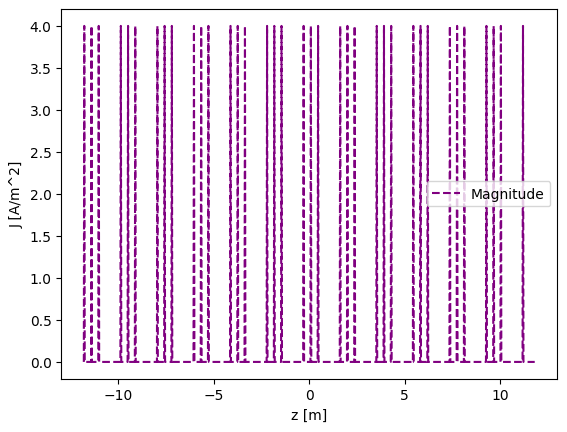

In [26]:
# Set up my case 
f = 53e6 # 96 MHz
kz0 = 4
nstraps = 61

myTWA = TWA_Design_Toolkit(num_straps=nstraps, f0=f, k_par_max=kz0)
myTWA.get_key_params(True)
myTWA.set_strap_width(w=0.01)
myTWA.plot_J_of_z(J0=4, zmin=-11.8, zmax=11.8)


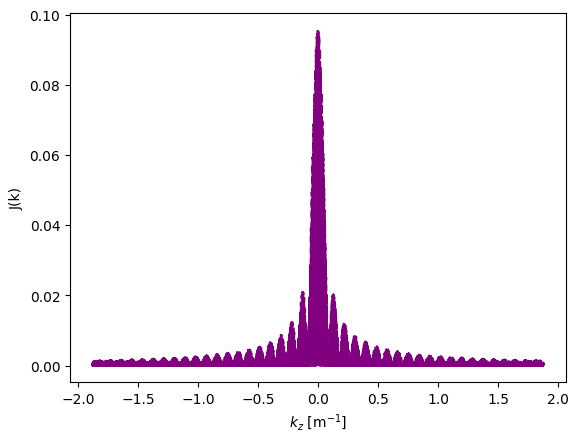

In [24]:
myTWA.plot_J_k_versus_k(zmin=-11.8, zmax=11.8, num_points=100000, J0=1)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

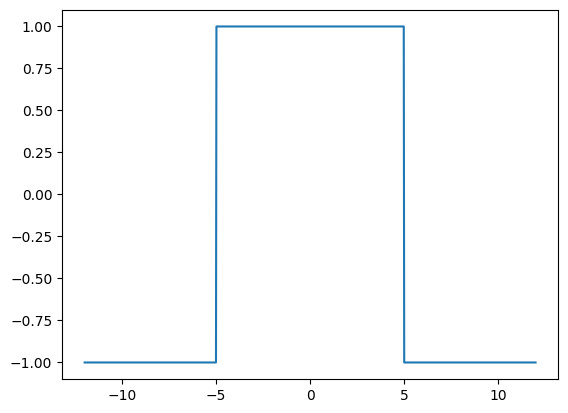

In [77]:
# Define your function J(z)
from scipy.signal import square

def J(z):
    # Define your function here, for example:
    d = 10/(2*np.pi)
    return square((z+5)*2*np.pi/20, duty=0.5) 

# Define the range of z values
num_points = 1000
zmin = -12
zmax = 12
z = np.linspace(zmin, zmax, num_points)
# Calculate J(z)
J_values = J(z)

# Perform Fourier transform
Jk = np.fft.fftshift(np.fft.fft(J_values))
# Define the corresponding k values
k = np.fft.fftshift(np.fft.fftfreq(len(z), d=z[1]-z[0]))
plt.plot(z, J_values)
print(J_values)

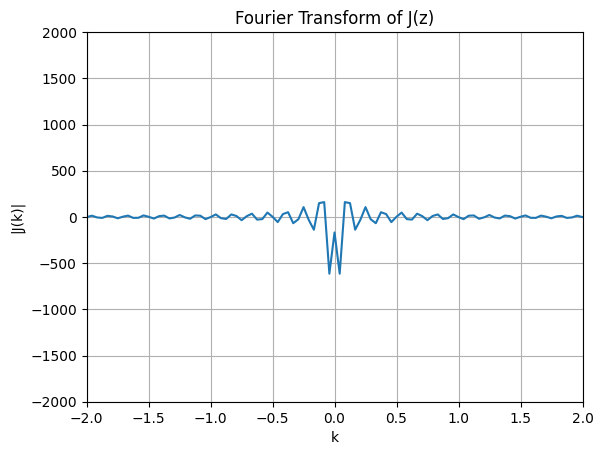

In [78]:
# Plot the Fourier transform
plt.plot(k, Jk)
plt.xlabel('k')
plt.ylabel('|J(k)|')
plt.title('Fourier Transform of J(z)')
plt.grid(True)
plt.axis([-2, 2, -2000, 2000])
plt.show()

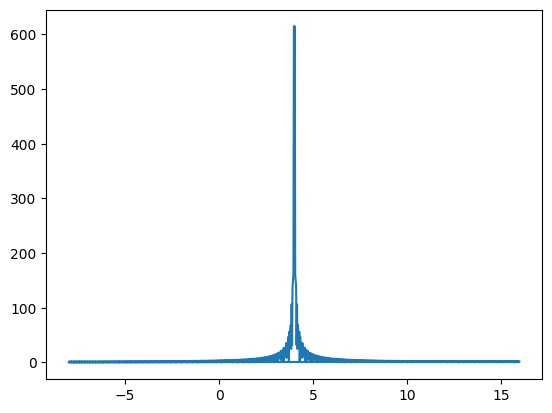

In [80]:
from scipy.fft import fft, fftfreq

yf = fft(J_values)
xf = fftfreq(num_points, 1/(zmax - zmin))
plt.plot(xf, np.abs(yf))

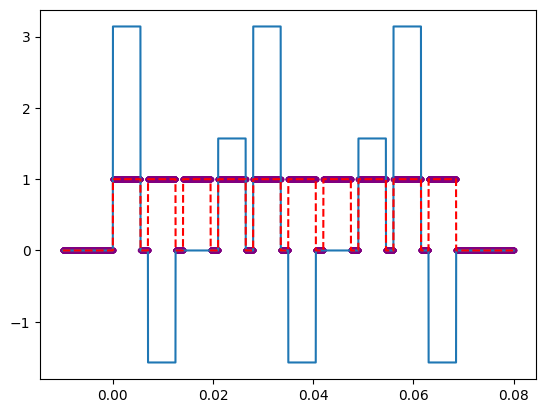

In [90]:
# try to reproduce Greg Wallace Thesus

wid = 0.0055
ds = 0.0015
num_l = 10
delphi = np.pi/2

def Ez(z, num_g, E0):
    g = wid + ds
    for n in range(num_g):
        if z >= (n*g) and z < ((n*g) + wid):
            return E0*np.exp(1j*n*delphi+1j*np.pi)
    return 0

num_points = 10000
zgrid = np.linspace(-.01, 0.08, num_points)
Ezs = np.zeros_like(zgrid, dtype='complex')

for i in range(zgrid.shape[0]):
    Ezs[i] = Ez(zgrid[i], num_l, 1)

plt.plot(zgrid, np.angle(Ezs))
plt.plot(zgrid, np.abs(Ezs), 'r--')
plt.scatter(zgrid, np.abs(Ezs), marker='.', color='purple')
    


